## Import packages

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    average_precision_score, confusion_matrix, log_loss, cohen_kappa_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler
import lime
import lime.lime_tabular
import shap
from sklearn.tree import plot_tree

## Load data, making sure to drop the serial number column, which is not useful for classification

In [108]:
train_df = pd.read_csv('datasets/train.csv', index_col=0)
test_df = pd.read_csv('datasets/test.csv', index_col=0)

## Clean data

In [109]:
train_df.head()

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,fm,Fm_2,EVENT
0,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,0
1,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,0
2,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,0
3,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,0
4,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,0


### Columns that have only one unique value aren't useful to classification, and should be dropped

In [110]:
train_df['Tp'].unique()

array([6.5       , 6.6       , 6.7       , ..., 9.00663063, 8.41352575,
       8.22963054], shape=(31635,))

In [111]:
test_df.head()

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,fm,Fm_2,EVENT
0,10.1,0.17,8.41,762.0,190.0,0.022,0.106,1818.0,920.0,0
1,10.1,0.18,8.41,762.0,190.0,0.022,0.106,1805.0,927.0,0
2,10.1,0.19,8.41,762.0,189.0,0.022,0.108,1787.0,927.0,0
3,10.1,0.18,8.41,762.0,190.0,0.022,0.108,1790.0,936.0,0
4,10.1,0.18,8.41,762.0,189.0,0.022,0.108,1827.0,924.0,0


In [112]:
test_df['EVENT'].unique()

array([0, 1])

## Check datatypes

In [113]:
train_df.dtypes

Tp       float64
Cl       float64
pH       float64
Redox    float64
Leit     float64
Trueb    float64
Cl_2     float64
fm       float64
Fm_2     float64
EVENT      int64
dtype: object

In [114]:
test_df.dtypes

Tp       float64
Cl       float64
pH       float64
Redox    float64
Leit     float64
Trueb    float64
Cl_2     float64
fm       float64
Fm_2     float64
EVENT      int64
dtype: object

## Format data for XGBoost

### Split test and training data into X_train, y_train, X_test, y_test

In [115]:
X_train = train_df.drop(columns=['EVENT']) # Features
y_train = train_df['EVENT'] # Labels
X_test = test_df.drop(columns=['EVENT'])
y_test = test_df['EVENT']

### Standardize data

In [134]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [117]:
X_train.head()

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,fm,Fm_2
0,-1.771856,0.171527,0.142346,0.262602,0.001509,-1.168076,0.718563,0.656364,-0.785325
1,-1.771856,0.171527,0.142346,0.262602,0.001509,-1.168076,0.718563,0.263442,-0.781309
2,-1.771856,0.171527,0.123621,0.262602,0.001509,-1.168076,0.678748,0.331187,-0.781309
3,-1.771856,0.171527,0.123621,0.262602,0.001509,-1.168076,0.718563,0.324413,-0.793356
4,-1.771856,0.171527,0.123621,0.262602,0.001509,-1.168076,0.718563,0.283766,-0.809419


In [118]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: EVENT, dtype: int64

In [119]:
X_test.head()

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,fm,Fm_2
0,1.521878,0.171527,0.235967,0.436665,-0.625861,0.133262,0.240790,1.133966,0.118186
1,1.521878,0.387174,0.235967,0.436665,-0.625861,0.133262,0.240790,1.089932,0.146296
2,1.521878,0.602822,0.235967,0.436665,-0.655736,0.133262,0.320419,1.028961,0.146296
3,1.521878,0.387174,0.235967,0.436665,-0.625861,0.133262,0.320419,1.039123,0.182436
4,1.521878,0.387174,0.235967,0.436665,-0.655736,0.133262,0.320419,1.164451,0.134249


In [120]:
y_test.head()

0    0
1    0
2    0
3    0
4    0
Name: EVENT, dtype: int64

## Build initial model with early stopping and default hyper params

In [121]:
start_time = time.time()

model = xgb.XGBClassifier(objective="binary:logistic", missing=np.nan, seed=42, early_stopping_rounds=10, eval_metric='auc', verbosity=1)

In [122]:
model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time:.4f} seconds")

[0]	validation_0-auc:0.50619
[1]	validation_0-auc:0.52072
[2]	validation_0-auc:0.64215
[3]	validation_0-auc:0.63995
[4]	validation_0-auc:0.65742
[5]	validation_0-auc:0.66540
[6]	validation_0-auc:0.63621
[7]	validation_0-auc:0.63801
[8]	validation_0-auc:0.61882
[9]	validation_0-auc:0.57368
[10]	validation_0-auc:0.57331
[11]	validation_0-auc:0.58541
[12]	validation_0-auc:0.58789
[13]	validation_0-auc:0.60866
[14]	validation_0-auc:0.60933
[15]	validation_0-auc:0.67603
[16]	validation_0-auc:0.68630
[17]	validation_0-auc:0.68781
[18]	validation_0-auc:0.69966
[19]	validation_0-auc:0.70483
[20]	validation_0-auc:0.67551
[21]	validation_0-auc:0.67524
[22]	validation_0-auc:0.67018
[23]	validation_0-auc:0.67561
[24]	validation_0-auc:0.69107
[25]	validation_0-auc:0.70065
[26]	validation_0-auc:0.70422
[27]	validation_0-auc:0.70749
[28]	validation_0-auc:0.70757
[29]	validation_0-auc:0.70565
[30]	validation_0-auc:0.70298
[31]	validation_0-auc:0.70273
[32]	validation_0-auc:0.70227
[33]	validation_0-au

## Get predictions from model

In [123]:
start_time = time.time()

y_pred = model.predict(X_test)

end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print the training time
print(f"Inference time: {training_time:.4f} seconds")

Inference time: 0.1344 seconds


## Plot confusion matrix

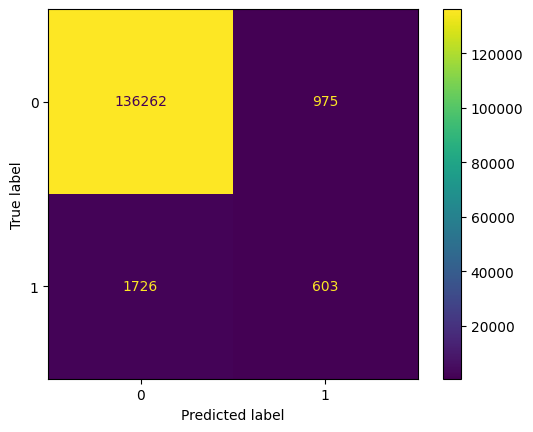

In [124]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Get other metrics

In [125]:
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for positive class only

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba))
print("PR-AUC (Average Precision): ", average_precision_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0,1]))
print("Log Loss: ", log_loss(y_test, y_pred_proba))
print("Cohen's Kappa: ", cohen_kappa_score(y_test, y_pred))

Accuracy:  0.9806471490191021
Precision:  0.3821292775665399
Recall:  0.2589094031773293
F1 Score:  0.30867673406705914
ROC-AUC:  0.7933104932949028
PR-AUC (Average Precision):  0.2890084561173501
Confusion Matrix:
 [[136262    975]
 [  1726    603]]
Log Loss:  0.10442518173654382
Cohen's Kappa:  0.29923050156569575


## Optimize hyper parameters using Bayesian Optimization and Cross Validation

### Round 1

In [126]:
# Function to optimize
def xgb_cv(gamma, learning_rate, max_depth, reg_lambda, scale_pos_weight):
    model = xgb.XGBClassifier(
        n_estimators=100,
        gamma=gamma,
        learning_rate=learning_rate,
        max_depth=int(max_depth),  # Must be integer
        reg_lambda=reg_lambda,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    return scores.mean()

In [127]:
param_grid = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'gamma': (0, 5),
    'reg_lambda': (0, 10),
    'scale_pos_weight': (1, 10)
}

In [128]:
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=param_grid,
    random_state=42,
    verbose=2
)

optimizer.maximize(
    init_points=5,
    n_iter=15
)

# Print best result
print("Best result:", optimizer.max)

|   iter    |  target   |   gamma   | learni... | max_depth | reg_la... | scale_... |
-------------------------------------------------------------------------------------


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:28:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:28:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:28:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 1         | 0.9969    | 1.873     | 0.2857    | 8.124     | 5.987     | 2.404     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:28:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:28:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:28:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 2         | 0.9872    | 0.78      | 0.02684   | 9.063     | 6.011     | 7.373     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 3         | 0.9958    | 0.1029    | 0.2913    | 8.827     | 2.123     | 2.636     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 4         | 0.9948    | 0.917     | 0.09823   | 6.673     | 4.319     | 3.621     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 5         | 0.9878    | 3.059     | 0.05045   | 5.045     | 3.664     | 5.105     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 6         | 0.9962    | 0.0       | 0.3       | 8.038     | 4.737     | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 7         | 0.996     | 3.635     | 0.08522   | 10.0      | 3.751     | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 8         | 0.9944    | 3.952     | 0.3       | 10.0      | 9.14      | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 9         | 0.9737    | 0.09265   | 0.01645   | 5.5       | 8.831     | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:29:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 10        | 0.9938    | 5.0       | 0.3       | 10.0      | 6.186     | 3.679     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 11        | 0.9966    | 3.058     | 0.3       | 7.029     | 0.0       | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 12        | 0.9969    | 0.0       | 0.3       | 4.354     | 0.0       | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 13        | 0.9903    | 5.0       | 0.3       | 10.0      | 0.0       | 10.0      |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 14        | 0.9952    | 5.0       | 0.3       | 10.0      | 0.0       | 2.99      |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 15        | 0.9945    | 4.9       | 0.3       | 3.0       | 0.0       | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 16        | 0.9955    | 5.0       | 0.3       | 6.66      | 3.626     | 1.0       |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 17        | 0.879     | 5.0       | 0.01      | 3.0       | 10.0      | 10.0      |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 18        | 0.9924    | 0.0       | 0.3       | 10.0      | 0.0       | 10.0      |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:31:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:31:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 19        | 0.9962    | 0.0       | 0.3       | 3.0       | 0.0       | 7.867     |


/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:31:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:31:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/goose/PythonProjects/water-quality-pred/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:31:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| 20        | 0.9824    | 2.867     | 0.01      | 6.365     | 0.0       | 5.855     |
Best result: {'target': np.float64(0.996908283905865), 'params': {'gamma': np.float64(1.8727005942368125), 'learning_rate': np.float64(0.28570714885887566), 'max_depth': np.float64(8.123957592679837), 'reg_lambda': np.float64(5.986584841970366), 'scale_pos_weight': np.float64(2.4041677639819286)}}


In [129]:
start_time = time.time()
optimized_model = xgb.XGBClassifier(
    seed=42,
    objective='binary:logistic',
    gamma=1.8727005942368125,
    learning_rate=0.28570714885887566,
    max_depth=8,
    reg_lambda=5.986584841970366,
    scale_pos_weight=2.4041677639819286,
    subsample=0.9,
    colsample_bytree=0.5,
    early_stopping_rounds=10,
    eval_metric='auc',
)

In [130]:
optimized_model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print the training time
print(f"Inference time: {training_time:.4f} seconds")

[0]	validation_0-auc:0.77461
[1]	validation_0-auc:0.77111
[2]	validation_0-auc:0.72460
[3]	validation_0-auc:0.76117
[4]	validation_0-auc:0.74615
[5]	validation_0-auc:0.74017
[6]	validation_0-auc:0.74362
[7]	validation_0-auc:0.78705
[8]	validation_0-auc:0.79183
[9]	validation_0-auc:0.79451
[10]	validation_0-auc:0.78551
[11]	validation_0-auc:0.77805
[12]	validation_0-auc:0.76639
[13]	validation_0-auc:0.76485
[14]	validation_0-auc:0.74954
[15]	validation_0-auc:0.74620
[16]	validation_0-auc:0.75958
[17]	validation_0-auc:0.77778
[18]	validation_0-auc:0.78229
[19]	validation_0-auc:0.80200
[20]	validation_0-auc:0.80197
[21]	validation_0-auc:0.79735
[22]	validation_0-auc:0.79355
[23]	validation_0-auc:0.79120
[24]	validation_0-auc:0.80967
[25]	validation_0-auc:0.80365
[26]	validation_0-auc:0.80680
[27]	validation_0-auc:0.80907
[28]	validation_0-auc:0.81390
[29]	validation_0-auc:0.82009
[30]	validation_0-auc:0.82227
[31]	validation_0-auc:0.82008
[32]	validation_0-auc:0.82005
[33]	validation_0-au

In [131]:
start_time = time.time()

y_pred = optimized_model.predict(X_test)

end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Print the training time
print(f"Training time: {training_time:.4f} seconds")

Training time: 0.1486 seconds


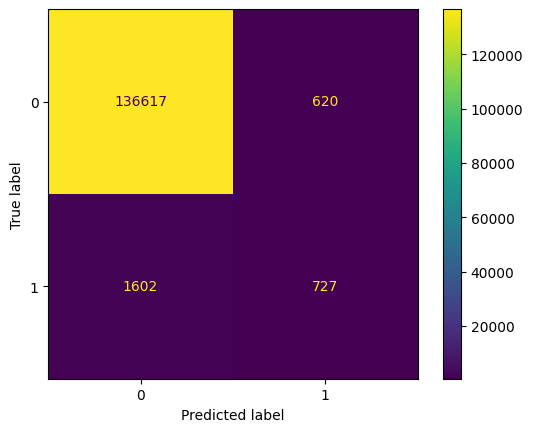

In [132]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [133]:
y_pred_proba = optimized_model.predict_proba(X_test)[:, 1] # Probabilities for positive class only

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_proba))
print("PR-AUC (Average Precision): ", average_precision_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0,1]))
print("Log Loss: ", log_loss(y_test, y_pred_proba))
print("Cohen's Kappa: ", cohen_kappa_score(y_test, y_pred))

Accuracy:  0.9840792170012754
Precision:  0.5397178916109874
Recall:  0.31215113782739373
F1 Score:  0.3955386289445049
ROC-AUC:  0.83700462135041
PR-AUC (Average Precision):  0.36566767256358845
Confusion Matrix:
 [[136617    620]
 [  1602    727]]
Log Loss:  0.06955097311843758
Cohen's Kappa:  0.3880547890840246


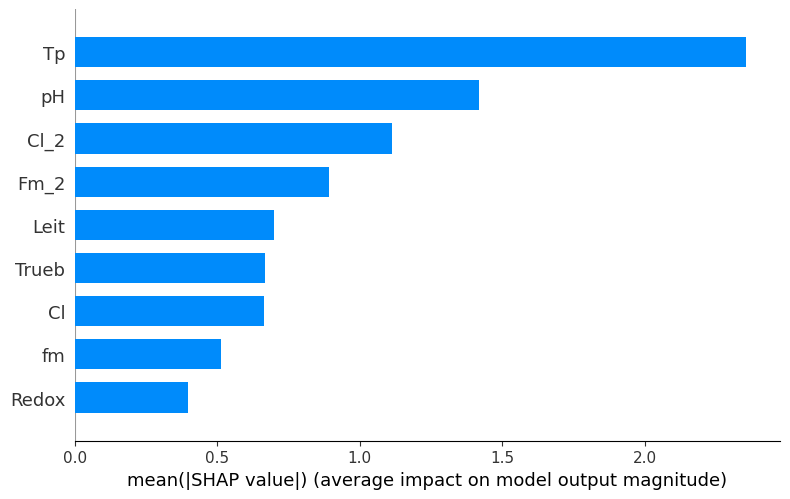

In [ ]:
shap_values = shap.TreeExplainer(optimized_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

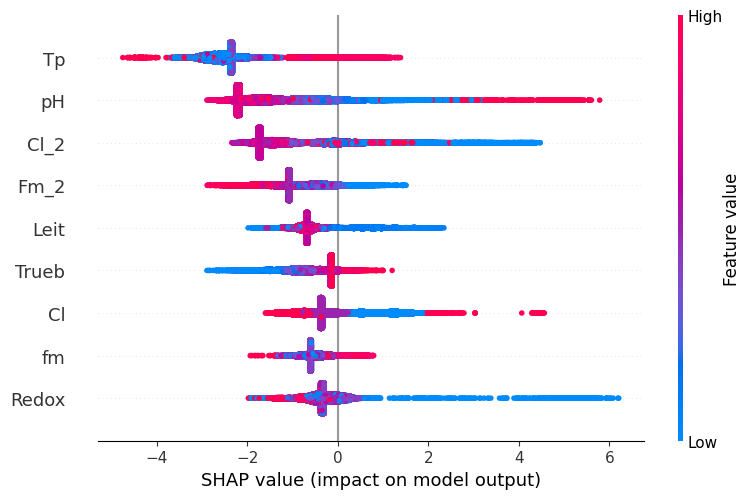

In [141]:
f = plt.figure()
shap.summary_plot(shap_values, X_test)